In [ ]:
import numpy as np
import cv2
import zmq
import time
import pickle
from matplotlib import pyplot as plt
import zlib

#Piotr's Retina
from utils import *

#Mani's Cythonised Retina
%cd cythonised_retina/scripts
import cv2
import numpy as np
from helpers import *
import classes as cy
%cd ../..

retina_layers = 'cythonised_retina/data/retina_layers.pkl'
left_path = 'cythonised_retina/data/left_path.pkl'
right_path = 'cythonised_retina/data/right_path.pkl'

video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'
beer = cv2.imread('beer.png')

/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline/cythonised_retina/scripts
/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline


## Piotr's Retina

In [ ]:
R = Retina(gpu=False)
R.loadLoc('/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline/retina_data/ret50k_loc.pkl')
R.loadCoeff('/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline/retina_data/ret50k_coeff.pkl')
fixation = (1080/2,1920/2)
shape = (1080, 1920)
R.prepare(shape, fixation)

V = R.sample(img, fixation).astype('uint8')

## Mani's Cythonised Retina

In [ ]:
cythonised_R = cy.Retina(retina_layers)
cythonised_R.calibrate(img)

cythonised_C = cy.Cortex(left_path, right_path)
cythonised_C.calibrate(cythonised_R.getResult())

In [ ]:
def send_image(n=5):
    video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'
    vidcap = cv2.VideoCapture(video_path)
    success, img = vidcap.read()

    count = 1
    pickling_times = []
    sending_times = []
    total_start = time.time()
    while success:
        if count%(n+1) == 0:
            break
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        t1 = time.time()
        
        data = pickle.dumps(img, protocol=-1)
        data = zlib.compress(data, 6)
        
        t2 = time.time()
        
        tracker = socket.send(data, copy=False, track=True)
        while tracker.done == False:
            pass
            
        t3 = time.time()
        
        pickling_times.append(t2-t1)
        sending_times.append(t3-t2)
        
        success, img = vidcap.read()
        count += 1
    total_end = time.time()
    socket.send(b'Done')
    socket.send_string(str(total_end-total_start))
    
    print('Successfully converted video to %d frames'%(count-1))
    
    print('\nProcessing time: %f'%sum(pickling_times))    
    print('Time taken to send: %f'%sum(sending_times))
    print('Overall total time: %f'%(total_end-total_start))

def send_encoded_image(n=5):
    video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'
    vidcap = cv2.VideoCapture(video_path)
    success, img = vidcap.read()

    count = 1
    pickling_times = []
    sending_times = []
    total_start = time.time()
    while success:
        if count%(n+1) == 0:
            break
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        t1 = time.time()
        
        #encoded_img, bits, code_dict, _ = huffman_encode(img.flatten())
        #data = [encoded_img, code_dict, bits]
        #data = pickle.dumps(data, protocol=-1)
        #data = zlib.compress(data, 6)
        data = pickle.dumps(img, protocol=-1)
        data = zlib.compress(data, 6)
        
        print(len(data))
        t2 = time.time()
        
        tracker = socket.send(data, copy=False, track=True)
        while tracker.done == False:
            pass
            
        t3 = time.time()
        
        pickling_times.append(t2-t1)
        sending_times.append(t3-t2)
        
        success, img = vidcap.read()
        count += 1
    total_end = time.time()
    socket.send(b'Done')
    socket.send_string(str(total_end-total_start))
    
    print('Successfully converted video to %d frames'%(count-1))
    
    print('\nProcessing time: %f'%sum(pickling_times))    
    print('Time taken to send: %f'%sum(sending_times))
    print('Overall total time: %f'%(total_end-total_start))

In [ ]:
def send_full_vector(n=5):
    video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'
    vidcap = cv2.VideoCapture(video_path)
    success, img = vidcap.read()

    count = 1
    processing_times = []
    sending_times = []
    total_start = time.time()
    
    while success:
        print(count)
        if count%n == 0:
            break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        t1 = time.time()
        
        V = R.sample(img, fixation).astype('uint8')
        V = pickle.dumps(V, protocol=-1)
        #V = V.tostring()
        
        t2 = time.time()
        
        tracker = socket.send(V, copy=False, track=True)
        while tracker.done == False:
            pass
            
        t3 = time.time()

        processing_times.append(t2-t1)
        sending_times.append(t3-t2)
        
        success, img = vidcap.read()
        count += 1
    total_end = time.time()
    print('Successfully converted video to %d frames'%count)
    
    print('\nProcessing time: %f'%sum(processing_times))    
    print('Time taken to send: %f'%sum(sending_times))
    print('Overall total time: %f'%(total_end-total_start))

def send_encoded_vector(n, cythonised=True):
    socket.send_string(str(cythonised))
    
    video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'
    vidcap = cv2.VideoCapture(video_path)
    success, img = vidcap.read()

    count = 1
    huffman_times = []
    sampling_times = []
    sending_times = []
    total_start = time.time()
    while success:
        print(count, end='\r')
        if count%(n+1) == 0:
            break
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        t1 = time.time()
        if cythonised:
            cythonised_R.sample(img)
            V = cythonised_R.sampledVector
        else:
            V = R.sample(img, fixation).astype('uint8')
        
        t2 = time.time()
        
        encoded_V, bits, code_dict, _ = huffman_encode(V.flatten())
        data = [encoded_V, code_dict, bits]
        data = pickle.dumps(data, protocol=-1)
        data = zlib.compress(data, 6)
        print(len(data))
        t3 = time.time()
        
        tracker = socket.send(data, copy=False, track=True)
        while tracker.done == False:
            pass

        t4 = time.time()
        
        sampling_times.append(t2-t1)
        huffman_times.append(t3-t2)
        sending_times.append(t4-t3)
        success, img = vidcap.read()
        count += 1
    total_end = time.time()
    
    socket.send(b'Done')
    socket.send_string(str(total_end-total_start))
    
    print('Successfully converted video to %d frames'%(count-1))
    
    print('\nSampling time: %f'%sum(sampling_times))
    print('Huffman encoding time: %f'%sum(huffman_times))
    print('Time taken to send: %f'%sum(sending_times))
    print('Overall total time: %f'%(total_end-total_start))

In [ ]:
context = zmq.Context()

#  Socket to talk to server
print("Connecting to Server…")
socket = context.socket(zmq.PUSH)
socket.connect("tcp://localhost:5555")
#time.sleep(2)

socket.send(b'Normal')
#Server expects a string to determine whether to use Mani's or Piotr's code
socket.send_string('')
send_encoded_image(n=10)
#send_image(n=10)

socket.close()

Connecting to Server…
2803301
2608612
2566492
2574694
2419883
2593186
2531033
2596641
2453962
2414264
Successfully converted video to 10 frames

Processing time: 1.910559
Time taken to send: 0.106785
Overall total time: 2.079431


In [ ]:
context = zmq.Context()

#  Socket to talk to server
print("Connecting to Server…")
socket = context.socket(zmq.PUSH)
socket.connect("tcp://localhost:5555")

socket.send(b'Cort')
send_encoded_vector(n=10, cythonised=False)

socket.close()

Connecting to Server…
136278
136355
136083
136362
135694
136241
135880
136338
135698
135867
Successfully converted video to 10 frames

Sampling time: 35.053354
Huffman encoding time: 0.070167
Time taken to send: 0.127150
Overall total time: 35.309664


In [ ]:
full = False

if full:
    data = img
else:
    encoded_V, bits, code_dict, _ = huffman_encode(V.flatten())
    data = [encoded_V, code_dict, bits]
    
data = pickle.dumps(data, protocol=-1)
data = zlib.compress(data, 6)
print(len(data))
print("Connecting to Server…")
socket = context.socket(zmq.PUSH)
socket.connect("tcp://localhost:5555")

times = []
for i in range(100):
    start = time.time()
    tracker = socket.send(data, copy=False, track=True)
    while not tracker.done:
        pass
    end = time.time()
    times.append(end-start)
print('Time taken %.5f'%sum(times))

144794
Connecting to Server…
Time taken 0.66782


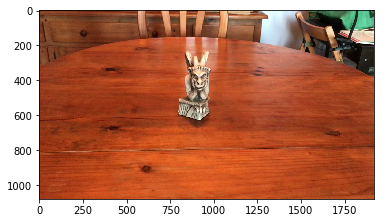

In [ ]:
video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'
vidcap = cv2.VideoCapture(video_path)
success, img = vidcap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

V = R.sample(img, fixation).astype('uint8').flatten()
beer_V = R.sample(beer, fixation).astype('uint8').flatten()

In [ ]:
print(len(np.unique(V)), len(np.unique(beer_V)))

encoded_V, bits, code_dict, _ = huffman_encode(V)
print(len(encoded_V), len(code_dict), bits)
data = [encoded_V, code_dict, bits]
data = pickle.dumps(data, protocol=-1)
print('Huffman only: %d'%len(data))

data = zlib.compress(data, 6)
print('Huffman + Zlib: %d'%len(data))


encoded_V, bits, code_dict, _ = huffman_encode(beer_V)
print(len(encoded_V), len(code_dict), bits)
data = [encoded_V, code_dict, bits]
data = pickle.dumps(data, protocol=-1)
print('Huffman only: %d'%len(data))

data = zlib.compress(data, 6)
print('Huffman + Zlib: %d'%len(data))

252 224
142840 252 1142719
Huffman only: 155819
Huffman + Zlib: 144794
129800 224 1038397
Huffman only: 141598
Huffman + Zlib: 130534


# Video transmission using Mani's cythonised Retina

In [ ]:
### This redefines Piotr's Retina
%cd cythonised_retina/scripts
import cv2
import numpy as np
from helpers import *
import classes as cy
%cd ../..

retina_layers = 'cythonised_retina/data/retina_layers.pkl'
left_path = 'cythonised_retina/data/left_path.pkl'
right_path = 'cythonised_retina/data/right_path.pkl'

video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'

img = cv2.imread('beer.png')

/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline/cythonised_retina/scripts
/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline


In [ ]:
R = cy.Retina(retina_layers)
R.calibrate(img)

#C = cy.Cortex(left_path, right_path)
#C.calibrate(R.getResult())

In [ ]:
#R.scalingFactor = np.float64(1)
R.sample(img)
#
print(np.unique(R.sampledVector))
R.sampledVector = R.sampledVector.astype('uint8').astype('uint64')
print(np.unique(R.sampledVector))

print(np.unique(R.normalizationVector))
#R.normalizationVector = R.normalizationVector.astype('uint8').astype('uint64')
#R.scalingFactor = R.scalingFactor.astype('uint8')
R.backProject()
#print(V[0][:10])
#print(V.astype('uint8')[0][:10])
bp = R.backProjectedVector.astype('uint8')

print(np.unique(bp))

[       0   379864   391385 ... 24524831 24839313 25110572]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231

In [ ]:
R.sample(img)

#V = R.sampledVector.astype('uint8')

#R.sampledVector = V.astype('uint64')
#R.scalingFactor = np.float64(1.2)# R.scalingFactor.astype('uint8').astype('float64')
C.backProject(R.getResult())
print(type(R.scalingFactor))


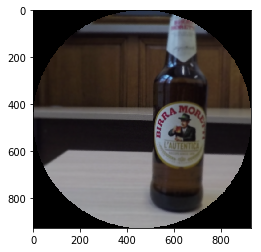

In [ ]:
from matplotlib import pyplot as plt
ret = get_retinaBackProjected_BGR(R)
#cort = get_cortexBackProjected_BGR(C)
plt.imshow(ret)